In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
#import pandas as pd

from IPython.display import display, HTML
import tensorflow as tf
#import numpy as np
#import pandas as pd
#import random as ran
import h5py

import pandas as pd


In [2]:
def Overlap_calc(hp,sp,psd):
    f_low = 30
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    o = overlap(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    return o


In [3]:
def _preprocess_data(data, num, samples):
    new_array = []
    for i in range(num):
        dataset = data[i]
        if((dataset.max() != 0.0) and (dataset.min() != 0.0)):
            maximum = np.max(dataset)
            minimum = np.abs(np.min(dataset))
            for j in range(samples):
                if(dataset[j] > 0):
                    dataset[j] = dataset[j]/maximum
                else:
                    dataset[j] = dataset[j]/minimum
        new_array.append(dataset)
    return new_array, maximum, minimum


In [4]:
# Split a univariate sequence into samples
#def split_sequence(sequence_noisy,sequence_pure,n_steps):
def split_sequence(sequence_noisy,n_steps):
    X = [] 
#    y = []
    for i in range(len(sequence_noisy)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence_noisy[i:end_ix] 
#        seq_y = sequence_pure[end_ix]
        X.append(seq_x)
#        y.append(seq_y)
#    return array(X), array(y)
    return np.array(X)
    
    
#def reshape_sequences(self, num, data_noisy, data_pure):
def reshape_sequences(num, data_noisy):
    n_steps = 15
    arr_noisy = []
#    arr_pure = []
        
    for i in range(num):
        X_noisy = data_noisy[i]
#        X_pure = data_pure[i]
        X_noisy = np.pad(X_noisy, (n_steps, n_steps), 'constant', constant_values=(0, 0))
#        X_pure = np.pad(X_pure, (n_steps, n_steps), 'constant', constant_values=(0, 0))
        # split into samples
#        X, y = self.split_sequence(X_noisy, X_pure, n_steps)
        X = split_sequence(X_noisy, n_steps)
        arr_noisy.append(X)
#        arr_pure.append(y)
    
    arr_noisy = np.asarray(arr_noisy)
#    arr_pure = np.asarray(arr_pure)
        
#    return arr_noisy, arr_pure
    return arr_noisy


In [5]:
class FractalTanimotoLoss(tf.keras.losses.Loss):
        def __init__(lr, base_lr=2e-3, depth=0, smooth=1e-6, **kwargs):
            depth = depth
            learning_rate = lr
            base_lr = base_lr
            smooth = smooth
            super().__init__(**kwargs)
    
        def inner_prod(self, y, x):
            prod = y*x
            prod = K.sum(prod, axis=1)
        
            return prod
    
        def tnmt_base(x, y, scale):

            tpl  = inner_prod(y,x)
            tpp  = inner_prod(y,y)
            tll  = inner_prod(x,x)


            num = tpl + self.smooth
            denum = 0.0
            result = 0.0
            for d in range(depth):
                a = 2.**d
                b = -(2.*a-1.)

                denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
                
            result =  num * denum * scale
            
            return  result*scale
        
        def call(y_true, y_pred):
            
            if(learning_rate < base_lr):
                depth = depth + 5
                
            depth = depth+1
            scale = 1./len(range(depth))
            
            l1 = K.mean(K.square(y_pred - y_true),axis=-1)
            result = tnmt_base(y_true, y_pred, scale)
        
            return  l1 - 0.01*result
        
        def get_config(self):
            base_config = super().get_config()
            return {**base_config, "depth": depth}   
    

In [6]:
class TimeDistributedMultiHeadAttention(tf.keras.layers.Layer):
        def __init__(self, num_heads, key_dim, **kwargs):
            super().__init__(**kwargs)
            self.num_heads = num_heads
            self.key_dim = key_dim
            self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        def call(self, inputs):
            # Use tf.shape for dynamic shape and inputs.shape for static shape
            shape = tf.shape(inputs)
            static_shape = inputs.shape
            batch_size, num_subsequences, subsequence_length = shape[0], static_shape[1], static_shape[2]
            features = static_shape[3]

            reshaped_inputs = tf.reshape(inputs, [-1, subsequence_length, features])

            # Apply multi-head attention to each subsequence individually
            attention_output = self.multi_head_attention(reshaped_inputs, reshaped_inputs)

            # Reshape the output back to the original input shape
            output_shape = [-1, num_subsequences, subsequence_length, features]
            return tf.reshape(attention_output, output_shape)

        def compute_output_shape(self, input_shape):
            return input_shape
        
        def get_config(self):
            config = super().get_config()
            config.update({
                'num_heads': self.num_heads,
                'key_dim': self.key_dim
            })
            return config


In [7]:
#f1 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-8to10_mchirp_all_500.hdf', 'r')
#f2 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-10to20_mchirp_all_500.hdf', 'r')
#f3 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-20to30_mchirp_all_500.hdf', 'r')
#f4 = h5py.File('/fred/oz016/Chayan/BBH_sample_files/O3b_test_IMRPhenomXPHM_SNR-30to40_mchirp_all_500.hdf', 'r')

f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_SNR-6to8_mchirp_all_250_30Hz_new.hdf', 'r')
f2 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_SNR-8to10_mchirp_all_250_30Hz_new.hdf', 'r')
f3 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_SNR-10to20_mchirp_all_250_30Hz_new.hdf', 'r')
f4 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_SNR-20to30_mchirp_all_250_30Hz_new.hdf', 'r')

strain_1 = f1['injection_samples']['l1_strain'][()]
strain_2 = f2['injection_samples']['l1_strain'][()]
strain_3 = f3['injection_samples']['l1_strain'][()]
strain_4 = f4['injection_samples']['l1_strain'][()]

signal_1 = f1['injection_parameters']['l1_signal_whitened'][()]
signal_2 = f2['injection_parameters']['l1_signal_whitened'][()]
signal_3 = f3['injection_parameters']['l1_signal_whitened'][()]
signal_4 = f4['injection_parameters']['l1_signal_whitened'][()]

strain = np.concatenate([strain_1, strain_2, strain_3, strain_4], axis=0)
signal = np.concatenate([signal_1, signal_2, signal_3, signal_4], axis=0)


In [8]:
mass_1_1 = f1['injection_parameters']['mass1'][()]
mass_1_2 = f2['injection_parameters']['mass1'][()]
mass_1_3 = f3['injection_parameters']['mass1'][()]
mass_1_4 = f4['injection_parameters']['mass1'][()]

mass_2_1 = f1['injection_parameters']['mass2'][()]
mass_2_2 = f2['injection_parameters']['mass2'][()]
mass_2_3 = f3['injection_parameters']['mass2'][()]
mass_2_4 = f4['injection_parameters']['mass2'][()]

snr_1 = f1['injection_parameters']['l1_snr'][()]*f1['injection_parameters']['scale_factor'][()]
snr_2 = f2['injection_parameters']['l1_snr'][()]*f2['injection_parameters']['scale_factor'][()]
snr_3 = f3['injection_parameters']['l1_snr'][()]*f3['injection_parameters']['scale_factor'][()]
snr_4 = f4['injection_parameters']['l1_snr'][()]*f4['injection_parameters']['scale_factor'][()]

spin_1a_1 = f1['injection_parameters']['spin1_a'][()]
spin_1a_2 = f2['injection_parameters']['spin1_a'][()]
spin_1a_3 = f3['injection_parameters']['spin1_a'][()]
spin_1a_4 = f4['injection_parameters']['spin1_a'][()]

spin_2a_1 = f1['injection_parameters']['spin2_a'][()]
spin_2a_2 = f2['injection_parameters']['spin2_a'][()]
spin_2a_3 = f3['injection_parameters']['spin2_a'][()]
spin_2a_4 = f4['injection_parameters']['spin2_a'][()]

spin_1_polar_1 = f1['injection_parameters']['spin1_polar'][()]
spin_1_polar_2 = f2['injection_parameters']['spin1_polar'][()]
spin_1_polar_3 = f3['injection_parameters']['spin1_polar'][()]
spin_1_polar_4 = f4['injection_parameters']['spin1_polar'][()]

spin_2_polar_1 = f1['injection_parameters']['spin2_polar'][()]
spin_2_polar_2 = f2['injection_parameters']['spin2_polar'][()]
spin_2_polar_3 = f3['injection_parameters']['spin2_polar'][()]
spin_2_polar_4 = f4['injection_parameters']['spin2_polar'][()]

spin_1_azimuthal_1 = f1['injection_parameters']['spin1_azimuthal'][()]
spin_1_azimuthal_2 = f2['injection_parameters']['spin1_azimuthal'][()]
spin_1_azimuthal_3 = f3['injection_parameters']['spin1_azimuthal'][()]
spin_1_azimuthal_4 = f4['injection_parameters']['spin1_azimuthal'][()]

spin_2_azimuthal_1 = f1['injection_parameters']['spin2_azimuthal'][()]
spin_2_azimuthal_2 = f2['injection_parameters']['spin2_azimuthal'][()]
spin_2_azimuthal_3 = f3['injection_parameters']['spin2_azimuthal'][()]
spin_2_azimuthal_4 = f4['injection_parameters']['spin2_azimuthal'][()]

inclination_1 = f1['injection_parameters']['inclination'][()]
inclination_2 = f2['injection_parameters']['inclination'][()]
inclination_3 = f3['injection_parameters']['inclination'][()]
inclination_4 = f4['injection_parameters']['inclination'][()]

psd_l1_1 = f1['injection_parameters']['psd_noise_l1'][()]
psd_l1_2 = f2['injection_parameters']['psd_noise_l1'][()]
psd_l1_3 = f3['injection_parameters']['psd_noise_l1'][()]
psd_l1_4 = f4['injection_parameters']['psd_noise_l1'][()]

mass_1 = np.concatenate([mass_1_1, mass_1_2, mass_1_3, mass_1_4], axis=0)
mass_2 = np.concatenate([mass_2_1, mass_2_2, mass_2_3, mass_2_4], axis=0)

snr = np.concatenate([snr_1, snr_2, snr_3, snr_4], axis=0)

spin1a = np.concatenate([spin_1a_1, spin_1a_2, spin_1a_3, spin_1a_4], axis=0)
spin2a = np.concatenate([spin_2a_1, spin_2a_2, spin_2a_3, spin_2a_4], axis=0)

spin1_polar = np.concatenate([spin_1_polar_1, spin_1_polar_2, spin_1_polar_3, spin_1_polar_4], axis=0)
spin2_polar = np.concatenate([spin_2_polar_1, spin_2_polar_2, spin_2_polar_3, spin_2_polar_4], axis=0)

spin1_azimuthal = np.concatenate([spin_1_azimuthal_1, spin_1_azimuthal_2, spin_1_azimuthal_3, spin_1_azimuthal_4], axis=0)
spin2_azimuthal = np.concatenate([spin_2_azimuthal_1, spin_2_azimuthal_2, spin_2_azimuthal_3, spin_2_azimuthal_4], axis=0)

inclination = np.concatenate([inclination_1, inclination_2, inclination_3, inclination_4], axis=0)

psd_l1 = np.concatenate([psd_l1_1, psd_l1_2, psd_l1_3, psd_l1_4], axis=0)


In [9]:
strain, maximum, minimum = _preprocess_data(strain, strain.shape[0], 2048)
strain = np.array(strain)
strain.shape


(1000, 2048)

In [10]:
X_test_strain = reshape_sequences(strain.shape[0], strain)
X_test_pure_signal = reshape_sequences(signal.shape[0], signal)


In [11]:
# Reshape arrays to fit into Keras model
X_test_strain = X_test_strain[:,:,:,None]
print('x_test_strain shape:', X_test_strain.shape)
X_test_strain = X_test_strain.astype("float32")

X_test_pure_signal = X_test_pure_signal[:,:,:,None]
print('x_test_pure_signal shape:', X_test_pure_signal.shape)
X_test_pure_signal = X_test_pure_signal.astype("float32")


x_test_strain shape: (1000, 2063, 15, 1)
x_test_pure_signal shape: (1000, 2063, 15, 1)


In [12]:
#from keras.models import load_model

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_old_model_4_timesteps_mchirp_all.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model1 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/trained_model_test_IMBH_HM_O3b_noise_mass_corrected.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

#model2 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model3 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model4 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model5 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model_1.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model6 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model_no_attention.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model7 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model_mse_loss.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

#model8 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model_mse_loss_1.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model9 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_25_timesteps_30Hz_mse_loss_larger_model.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})

#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_4_timesteps_old_model_new_training_data.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'AttentionLayer': AttentionLayer})    

#model10 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_30Hz_mse_loss_larger_model_encoder_attention.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention})

model11 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_30Hz_mse_loss_larger_model_encoder_attention_1.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention})
model12 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_15_timesteps_30Hz_mse_loss_larger_model_MHA.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss, 'TimeDistributedMultiHeadAttention': TimeDistributedMultiHeadAttention})


# load model
#model = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_dilated_CNN_25_timesteps.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

# summarize model.
model12.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 2063, 15, 1)      4         
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (None, 2063, 15, 64)     256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2063, 15, 32)     6176      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2063, 15, 32)     3104      
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 2063, 15, 32)      0

In [13]:
#decoded_signals1 = model1.predict(X_test_strain, batch_size=50)
#decoded_signals2 = model2.predict(X_test_strain, batch_size=50)
#decoded_signals3 = model3.predict(X_test_strain, batch_size=50)
#decoded_signals4 = model4.predict(X_test_strain, batch_size=50)
#decoded_signals5 = model5.predict(X_test_strain, batch_size=50)
#decoded_signals6 = model6.predict(X_test_strain, batch_size=50)
#decoded_signals7 = model7.predict(X_test_strain, batch_size=50)
#decoded_signals8 = model8.predict(X_test_strain, batch_size=50)
#decoded_signals9 = model9.predict(X_test_strain, batch_size=50)
#decoded_signals10 = model10.predict(X_test_strain, batch_size=50)
decoded_signals11 = model11.predict(X_test_strain, batch_size=50)
decoded_signals12 = model12.predict(X_test_strain, batch_size=50)


In [14]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

#overlaps1 = []
#overlaps2 = []
#overlaps3 = []
#overlaps4 = []
#overlaps5 = []
#overlaps6 = []
#overlaps7 = []
#overlaps8 = []
#overlaps9 = []
##overlaps10 = []
overlaps11 = []
overlaps12 = []

def get_overlap(decoded_signal, pure_signal, psd):
    
    time_buffer = 1
    length_signal = len(decoded_signal)

    f_low = 30
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    psd = FrequencySeries(psd, delta_f=delta_f)
    
    X_test_pure_ts = TimeSeries(pure_signal.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signal.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    
    return m

for i in range(decoded_signals12.shape[0]):
#    overlaps1.append(get_overlap(decoded_signals1[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps2.append(get_overlap(decoded_signals2[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps3.append(get_overlap(decoded_signals3[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps4.append(get_overlap(decoded_signals4[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps5.append(get_overlap(decoded_signals5[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps6.append(get_overlap(decoded_signals6[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps7.append(get_overlap(decoded_signals7[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps8.append(get_overlap(decoded_signals8[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps9.append(get_overlap(decoded_signals9[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
#    overlaps10.append(get_overlap(decoded_signals10[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    overlaps11.append(get_overlap(decoded_signals11[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    overlaps12.append(get_overlap(decoded_signals12[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    

In [15]:
#overlaps_10_18Hz_training = np.array(overlaps1)
#overlaps_10_30Hz_training = np.array(overlaps2)
#overlaps_10_30Hz_training_FT_loss = np.array(overlaps3)
#overlaps_10_30Hz_training_FT_loss_larger_model = np.array(overlaps4)
#overlaps_10_30Hz_training_FT_loss_larger_model_1 = np.array(overlaps5)
#overlaps_10_30Hz_training_FT_loss_larger_model_no_attention = np.array(overlaps6)
#overlaps_10_30Hz_training_FT_loss_larger_model_no_attention_mse = np.array(overlaps7)
#overlaps_10_30Hz_training_FT_loss_larger_model_no_attention_mse_larger = np.array(overlaps8)
#overlaps_25_30Hz_training_FT_loss_larger_model_no_attention_mse_larger = np.array(overlaps9)
#overlaps_10_30Hz_training_multihead_attention_mse = np.array(overlaps10)
overlaps_10_30Hz_training_multihead_attention_mse_1 = np.array(overlaps11)
overlaps_10_30Hz_training_multihead_attention_mse_2 = np.array(overlaps12)


In [16]:
def get_chirp_mass(mass1, mass2):
     
    return ((mass1*mass2)**(3.0/5))/(mass_1+mass_2)**(1.0/5) 
    
m_chirp = get_chirp_mass(mass_1, mass_2)


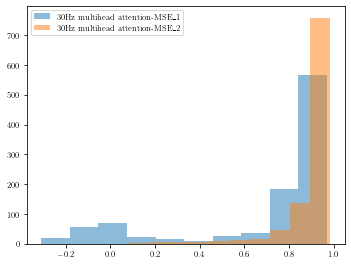

In [31]:
#plt.hist(overlaps_10_18Hz_training, alpha=0.5, label='18Hz')
#plt.hist(overlaps_10_30Hz_training, alpha=0.5, label='30Hz')
#plt.hist(overlaps_10_30Hz_training_FT_loss, alpha=0.5, label='30Hz FT')
#plt.hist(overlaps_10_30Hz_training_FT_loss_larger_model, alpha=0.5,label='30Hz FT larger model')
#plt.hist(overlaps_10_30Hz_training_FT_loss_larger_model_1, alpha=0.5,label='30Hz FT larger model-MAE+weight*MSE')
#plt.hist(overlaps_10_30Hz_training_FT_loss_larger_model_no_attention, alpha=0.5,label='30Hz FT larger model-no attention')
#plt.hist(overlaps_10_30Hz_training_FT_loss_larger_model_no_attention_mse, alpha=0.5,label='30Hz larger model-no attention-MSE')
#plt.hist(overlaps_10_30Hz_training_FT_loss_larger_model_no_attention_mse_larger, alpha=0.5,label='30Hz FT larger model-no attention-MSE_larger')
#plt.hist(overlaps_25_30Hz_training_FT_loss_larger_model_no_attention_mse_larger, alpha=0.5,label='30Hz FT larger model-no attention-MSE(25 tsteps)')
#plt.hist(overlaps_10_30Hz_training_multihead_attention_mse, alpha=0.5,label='30Hz multihead attention-MSE')
plt.hist(overlaps_10_30Hz_training_multihead_attention_mse_1, alpha=0.5,label='30Hz multihead attention-MSE_1')
plt.hist(overlaps_10_30Hz_training_multihead_attention_mse_2, alpha=0.5,label='30Hz multihead attention-MSE_2')

plt.legend()


<ipython-input-51-f7f7b21e0d76>:56: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Overlap_vs_Chirp_Mass.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


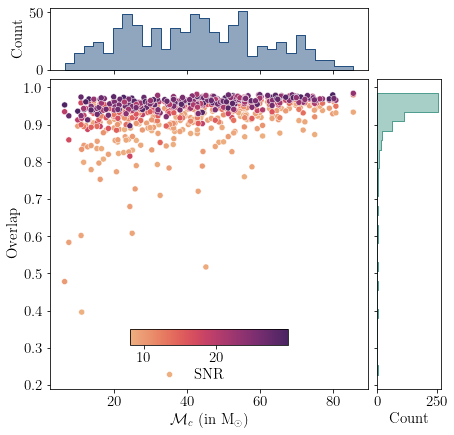

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, overlaps_10_30Hz_training, and m_chirp are defined arrays

index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 > 0.2))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

# Define the color palettes
palette_flare = sns.color_palette("flare", n_colors=5)
palette_crest = sns.color_palette("crest", n_colors=5)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(vmin=np.min(snr[index]), vmax=np.max(snr[index]))
sns.scatterplot(x=m_chirp[index], y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], hue=snr[index], 
                palette="flare", legend=False, ax=ax_scatter)
ax_scatter.set_ylabel('Overlap', fontsize=15)
ax_scatter.set_xlabel('$\mathcal{M}_{c}$ (in M$_{\odot}$)', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('SNR', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
sns.histplot(y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], bins=30, kde=False, 
             color=palette_crest[1], alpha=0.5, ax=ax_histy, element="step")
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=m_chirp[index], bins=30, kde=False, color=palette_crest[4], alpha=0.5, ax=ax_histx, element="step")
ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)

plt.savefig('Paper_plots_new/Overlap_vs_Chirp_Mass.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


In [25]:
overlap_reconst = overlaps_10_30Hz_training_multihead_attention_mse_2[index]

len(overlap_reconst[overlap_reconst>0.9])/len(overlap_reconst)

0.8586666666666667

In [26]:
len(overlap_reconst)

750

<ipython-input-53-13f963d22715>:52: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Overlap_vs_SNR_chirp_mass.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


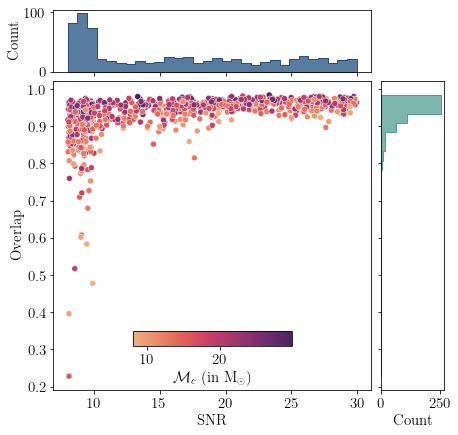

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, overlaps_10_30Hz_training, and m_chirp are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 > 0.2))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

# Define the color palette
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(vmin=np.min(snr[index]), vmax=np.max(snr[index]))

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=snr[index], y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], hue=m_chirp[index], 
                palette="flare", legend=False, ax=ax_scatter)
ax_scatter.set_xlabel('SNR', fontsize=15)
ax_scatter.set_ylabel('Overlap', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('$\mathcal{M}_{c}$ (in M$_{\odot}$)', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=snr[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)

plt.savefig('Paper_plots_new/Overlap_vs_SNR_chirp_mass.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


<ipython-input-55-8cee36c4bdd0>:52: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Overlap_vs_Mass_ratio.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


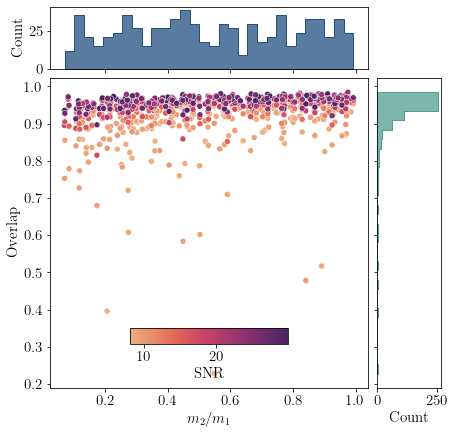

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, overlaps_10_30Hz_training, mass_1, and mass_2 are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 > 0.2))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

# Define the color palette
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(vmin=np.min(snr[index]), vmax=np.max(snr[index]))

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=mass_2[index]/mass_1[index], y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], hue=snr[index], 
                palette="flare", legend=False, ax=ax_scatter)
ax_scatter.set_xlabel('$m_{2}/m_{1}$', fontsize=15)
ax_scatter.set_ylabel('Overlap', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('SNR', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=mass_2[index]/mass_1[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)

plt.savefig('Paper_plots_new/Overlap_vs_Mass_ratio.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, snr_pure, snr_denoised, and overlaps_10_30Hz_training_multihead_attention_mse_1 are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 >= 0.2))
index = index[0][index[0] > 200]
index_noise = np.where(snr_denoised_noise < 4)

f_factor = (snr[index] / snr_pure[index])

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=f_factor * snr_pure[index], y=f_factor * snr_denoised[index], size=4, hue=overlaps_10_30Hz_training_multihead_attention_mse_2[index], 
                palette='flare', legend=False, ax=ax_scatter)
x = np.linspace(8, 30.0, 400)
y = x
ax_scatter.plot(x, y, '--')
ax_scatter.set_xlabel('Injected SNR', fontsize=15)
ax_scatter.set_ylabel('Recovered SNR', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=6.0)
cmap = sns.color_palette("flare", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(overlaps_10_30Hz_training_multihead_attention_mse_2[index]), vmax=np.max(overlaps_10_30Hz_training_multihead_attention_mse_2[index])))
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('Overlaps', fontsize=15, labelpad=10, rotation=0)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=f_factor * snr_denoised[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
sns.histplot(y=snr_denoised_noise[index_noise], bins=10, color=palette_crest[2], element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=f_factor * snr_pure[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)
ax_histx.tick_params(axis="x", labelbottom=False)

# Uncomment to save the figure
# plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_1.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)

plt.show()


NameError: name 'snr' is not defined

In [57]:
def get_chi_p(m1, m2, spin1a, spin2a, theta_1, theta_2):
     
    q = m2/m1
    
    a = spin1a*np.sin(theta_1)
    
    b1 = (q*(4*q+3))/(4+3*q)
    
    b2 = spin2a*np.sin(theta_2)
    
    return np.maximum(a, (b1*b2))
    
chi_p = get_chi_p(mass_1, mass_2, spin1a, spin2a, spin1_polar, spin2_polar)


<ipython-input-58-23f64609e994>:52: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Overlap_vs_Chi_p.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


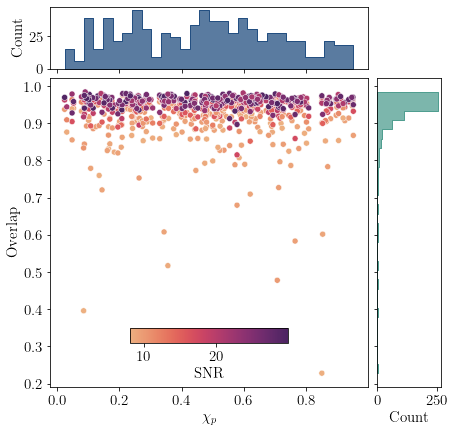

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, overlaps_10_30Hz_training, chi_p are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 > 0.2))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

# Define the color palette
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(vmin=np.min(snr[index]), vmax=np.max(snr[index]))

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=chi_p[index], y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], hue=snr[index], 
                palette="flare", legend=False, ax=ax_scatter)
ax_scatter.set_xlabel('$\chi_{p}$', fontsize=15)
ax_scatter.set_ylabel('Overlap', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('SNR', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=chi_p[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)

plt.savefig('Paper_plots_new/Overlap_vs_Chi_p.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


<ipython-input-59-8a37c6736203>:52: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Overlap_vs_inclination.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


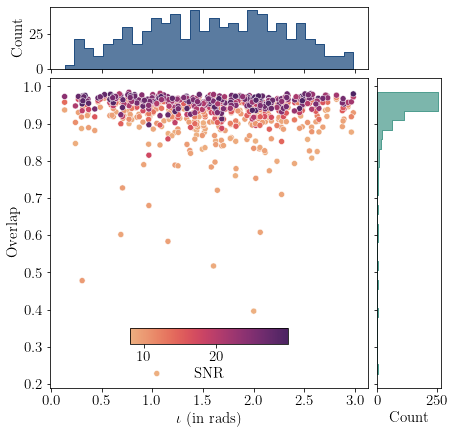

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, overlaps_10_30Hz_training, and inclination are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 > 0.2))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

# Define the color palette
cmap = sns.color_palette("flare", as_cmap=True)
norm = plt.Normalize(vmin=np.min(snr[index]), vmax=np.max(snr[index]))

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=inclination[index], y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], hue=snr[index], 
                palette="flare", legend=False, ax=ax_scatter)
ax_scatter.set_xlabel('$\iota$ (in rads)', fontsize=15)
ax_scatter.set_ylabel('Overlap', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=5.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('SNR', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=overlaps_10_30Hz_training_multihead_attention_mse_2[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=inclination[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)

plt.savefig('Paper_plots_new/Overlap_vs_inclination.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


In [21]:
from scipy.fft import fft, ifft

def get_snr_frac(decoded_signal):
    
    h_fft = fft(decoded_signal)
    template_fft = fft(decoded_signal)
    snr_freq = (h_fft * template_fft.conjugate())
    snr_time = np.abs(ifft(snr_freq))
    optimal_snr_ml = np.sqrt(np.max(snr_time))

    return optimal_snr_ml


In [22]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_noise_200_30Hz_new.hdf', 'r')

noise_strain = f1['noise_samples']['l1_strain'][0:500][()]
noise_strain, maximum, minimum = _preprocess_data(noise_strain, noise_strain.shape[0], 2048)
noise_strain = np.array(noise_strain)
noise_strain.shape


(200, 2048)

In [23]:
X_test_noise = reshape_sequences(noise_strain.shape[0], noise_strain)

# Reshape arrays to fit into Keras model
X_test_noise = X_test_noise[:,:,:,None]
print('x_test_strain shape:', X_test_noise.shape)
X_test_noise = X_test_noise.astype("float32")

x_test_strain shape: (200, 2063, 15, 1)


In [24]:
#model7 = tf.keras.models.load_model('/fred/oz016/Chayan/GW-Denoiser/model/model_IMRPhenomXPHM_O3b_noise_10_timesteps_attention_30Hz_FT_loss_larger_model_mse_loss.h5', custom_objects={'FractalTanimotoLoss': FractalTanimotoLoss})

denoised_noise = model12.predict(X_test_noise, batch_size=50)

In [25]:
snr_denoised = []
snr_denoised_noise = []
snr_pure = []

snr_frac = []

for i in range(decoded_signals11.shape[0]):
    snr_denoised.append(get_snr_frac((decoded_signals12[i].squeeze()).astype('float64')))
    snr_pure.append(get_snr_frac((signal[i]).astype('float64')))

for i in range(denoised_noise.shape[0]):
    snr_denoised_noise.append(get_snr_frac((denoised_noise[i].squeeze()).astype('float64')))
    
snr_denoised = np.array(snr_denoised)
snr_pure = np.array(snr_pure)

snr_denoised_noise = np.array(snr_denoised_noise)

snr_frac = snr_denoised/snr_pure


In [32]:
np.median(snr/snr_pure)

2.1210883783711654

In [36]:
snr_denoised_noise_ff = snr_denoised_noise*np.median(snr/snr_pure)

/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


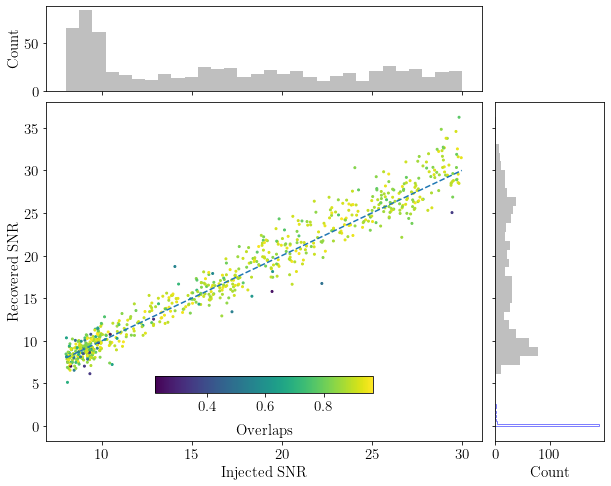

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, snr_pure, snr_denoised, and overlaps_10_30Hz_training_multihead_attention_mse_1 are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 >= 0.2))
#index = index[0][index[0]>200]
index_noise = np.where(snr_denoised_noise < 4)

f_factor = (snr[index] / snr_pure[index])

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
scatter = ax_scatter.scatter(f_factor * snr_pure[index], f_factor * snr_denoised[index], s=4, c=overlaps_10_30Hz_training_multihead_attention_mse_1[index], cmap='viridis')
x = np.linspace(8, 30.0, 400)
y = x
ax_scatter.plot(x, y, '--')
ax_scatter.set_ylabel('Recovered SNR', fontsize=15)
ax_scatter.set_xlabel('Injected SNR', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.hist(f_factor * snr_denoised[index], bins=30, orientation='horizontal', color='gray', alpha=0.5)
ax_histy.hist(snr_denoised_noise, bins=10, orientation='horizontal', color='blue', alpha=0.5, histtype='step')
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis='y', which='both', left=True, labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0])
ax_histx.hist(f_factor * snr_pure[index], bins=30, color='gray', alpha=0.5)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)
ax_histx.set_xticklabels([])
ax_histx.tick_params(axis="x", labelbottom=False)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=6.0)
cbar = plt.colorbar(scatter, cax=axins, orientation='horizontal')
cbar.set_label('Overlaps', fontsize=15, labelpad=10, rotation=0)
cbar.ax.tick_params(labelsize=15)
#cbar.ax.xaxis.set_label_position('top')

# Uncomment to save the figure
#plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_1.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)

# Show the plot
plt.show()


Text(0.5, 0.98, 'RMS of Residuals: 1.65, Variance of Residuals: 2.70')

/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


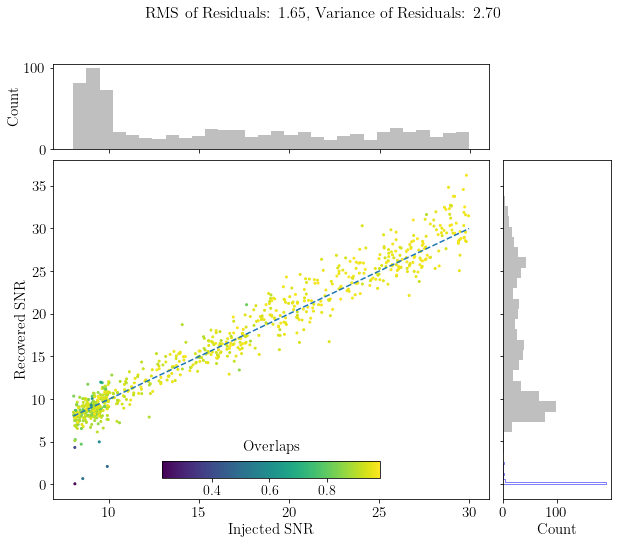

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, snr_pure, snr_denoised, and overlaps_10_30Hz_training_multihead_attention_mse_1 are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 >= 0.2))
index = index[0][index[0]>200]
index_noise = np.where(snr_denoised_noise<4)

f_factor = (snr[index] / snr_pure[index])

# Calculating residuals
residuals = (f_factor * snr_denoised[index]) - (f_factor * snr_pure[index])
rms_residuals = np.sqrt(np.mean(residuals**2))
variance_residuals = np.var(residuals)

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
scatter = ax_scatter.scatter(f_factor * snr_pure[index], f_factor * snr_denoised[index], s=4, c=overlaps_10_30Hz_training_multihead_attention_mse_2[index], cmap='viridis')
x = np.linspace(8, 30.0, 400)
y = x
ax_scatter.plot(x, y, '--')
ax_scatter.set_ylabel('Recovered SNR', fontsize=15)
ax_scatter.set_xlabel('Injected SNR', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15) 

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1])
ax_histy.hist(f_factor * snr_denoised[index], bins=30, orientation='horizontal', color='gray', alpha=0.5)
ax_histy.hist(snr_denoised_noise[index_noise], bins=10, orientation='horizontal', color='blue', alpha=0.5, histtype='step')
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.set_yticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0])
ax_histx.hist(f_factor * snr_pure[index], bins=30, color='gray', alpha=0.5)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)
ax_histx.set_xticklabels([])
ax_histx.tick_params(axis="x", labelbottom=False)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=2.7)
cbar = plt.colorbar(scatter, cax=axins, orientation='horizontal')
cbar.set_label('Overlaps', fontsize=15, labelpad=10, rotation=0)
cbar.ax.tick_params(labelsize=14)
cbar.ax.xaxis.set_label_position('top')

# Display RMS and variance of residuals
fig.suptitle(f'RMS of Residuals: {rms_residuals:.2f}, Variance of Residuals: {variance_residuals:.2f}', fontsize=16)

# Saving and showing the plot
#plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_snr>=8.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
# plt.show()


<ipython-input-44-fc720afdbac1>:58: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_1.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)
/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


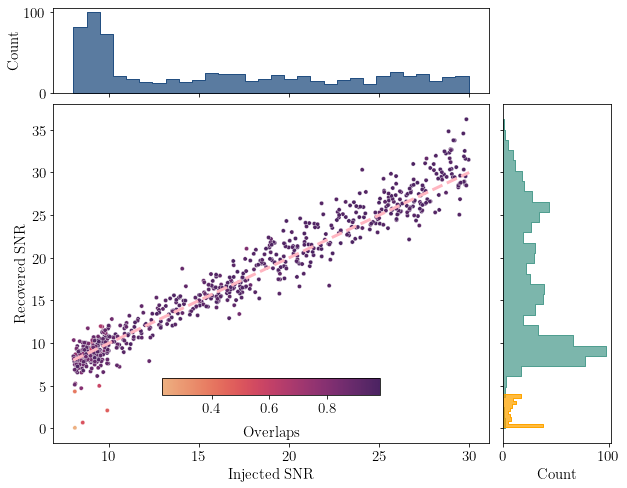

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

#f1 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/model/snr_denoised_noise.hdf', 'r')
#snr_denoised_noise = f1['snr_denoised_noise'][()]

# Assuming snr, snr_pure, snr_denoised, and overlaps_10_30Hz_training_multihead_attention_mse_1 are defined arrays
index = np.where((snr >= 8.0) & (overlaps_10_30Hz_training_multihead_attention_mse_2 >= 0.2))
index = index[0][index[0] > 200]
#index_noise = np.where(snr_denoised_noise < 4)

f_factor = (snr[index] / snr_pure[index])

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=f_factor * snr_pure[index], y=f_factor * snr_denoised[index], size=4, hue=overlaps_10_30Hz_training_multihead_attention_mse_2[index], 
                palette='flare', legend=False, ax=ax_scatter)
x = np.linspace(8, 30.0, 400)
y = x
ax_scatter.plot(x, y, '--', color='lightpink', linewidth=3)
ax_scatter.set_xlabel('Injected SNR', fontsize=15)
ax_scatter.set_ylabel('Recovered SNR', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=6.0)
cmap = sns.color_palette("flare", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(overlaps_10_30Hz_training_multihead_attention_mse_2[index]), vmax=np.max(overlaps_10_30Hz_training_multihead_attention_mse_2[index])))
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('Overlaps', fontsize=15, labelpad=10, rotation=0)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=f_factor * snr_denoised[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
sns.histplot(y=snr_denoised_noise[index_noise], bins=10, color='orange', element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=f_factor * snr_pure[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)
ax_histx.tick_params(axis="x", labelbottom=False)

# Uncomment to save the figure
plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_1.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)

plt.show()


In [34]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_SNR-8to30_mchirp_all_1000_30Hz_new.hdf', 'r')

strain = f1['injection_samples']['l1_strain'][()]
signal = f1['injection_parameters']['l1_signal_whitened'][()]
psd_l1 = f1['injection_parameters']['psd_noise_l1'][()]
snr = f1['injection_parameters']['l1_snr'][()]*f1['injection_parameters']['scale_factor'][()]

#f2 = h5py.File('/fred/oz016/Chayan/GW-Denoiser/model/snr_denoised_noise.hdf', 'r')
#snr_denoised_noise = f2['snr_denoised_noise'][()]

strain, maximum, minimum = _preprocess_data(strain, strain.shape[0], 2048)
strain = np.array(strain)

X_test_strain = reshape_sequences(strain.shape[0], strain)
X_test_pure_signal = reshape_sequences(signal.shape[0], signal)

# Reshape arrays to fit into Keras model
X_test_strain = X_test_strain[:,:,:,None]
print('x_test_strain shape:', X_test_strain.shape)
X_test_strain = X_test_strain.astype("float32")

X_test_pure_signal = X_test_pure_signal[:,:,:,None]
print('x_test_pure_signal shape:', X_test_pure_signal.shape)
X_test_pure_signal = X_test_pure_signal.astype("float32")

decoded_signals_new = model12.predict(X_test_strain, batch_size=50)

snr_denoised = []
snr_pure = []

snr_frac = []

for i in range(1000):
    snr_denoised.append(get_snr_frac((decoded_signals_new[i].squeeze()).astype('float64')))
    snr_pure.append(get_snr_frac((signal[i]).astype('float64')))
    
snr_denoised = np.array(snr_denoised)
snr_pure = np.array(snr_pure)

snr_frac = snr_denoised/snr_pure


x_test_strain shape: (1000, 2063, 15, 1)
x_test_pure_signal shape: (1000, 2063, 15, 1)


In [35]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt


overlaps_new = []

def get_overlap(decoded_signal, pure_signal, psd):
    
    time_buffer = 1
    length_signal = len(decoded_signal)

    f_low = 30
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    psd = FrequencySeries(psd, delta_f=delta_f)
    
    X_test_pure_ts = TimeSeries(pure_signal.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signal.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    
    return m

for i in range(decoded_signals_new.shape[0]):
    
    overlaps_new.append(get_overlap(decoded_signals_new[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    

In [37]:
overlaps_new = np.array(overlaps_new)

/fred/oz016/Chayan/tensorflow2.7/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


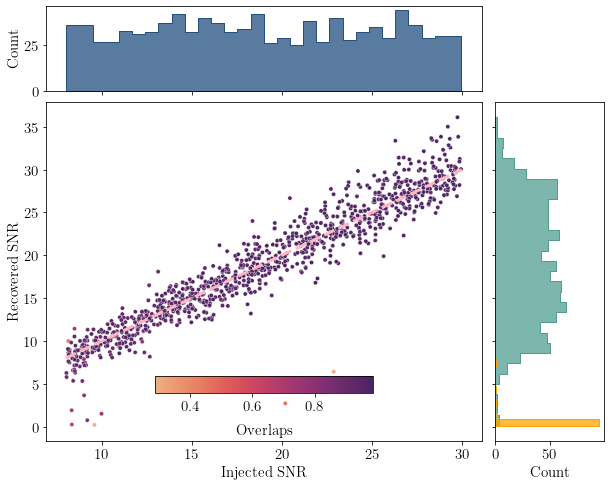

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Assuming snr, snr_pure, snr_denoised, and overlaps_10_30Hz_training_multihead_attention_mse_2 are defined arrays
index = np.where((overlaps_new >= 0.2))
index_noise = np.where(snr_denoised_noise < 4)

f_factor = (snr[index] / snr_pure[index])

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05)

# Main scatter plot
ax_scatter = plt.subplot(gs[1, 0])
sns.scatterplot(x=f_factor * snr_pure[index], y=f_factor * snr_denoised[index], size=4, hue=overlaps_new[index], 
                palette='flare', legend=False, ax=ax_scatter)
x = np.linspace(8, 30.0, 400)
y = x
ax_scatter.plot(x, y, '--', color='lightpink', linewidth=3)
ax_scatter.set_xlabel('Injected SNR', fontsize=15)
ax_scatter.set_ylabel('Recovered SNR', fontsize=15)
ax_scatter.tick_params(axis='both', labelsize=15)
ax_scatter.grid(False)  # Turn off gridlines

# Create horizontal colorbar inside scatter plot
axins = inset_axes(ax_scatter, width="50%", height="5%", loc='lower center', borderpad=6.0)
cmap = sns.color_palette("flare", as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(overlaps_new[index]), vmax=np.max(overlaps_new[index])))
cbar = plt.colorbar(sm, cax=axins, orientation='horizontal')
cbar.set_label('Overlaps', fontsize=15, labelpad=10, rotation=0)
cbar.ax.tick_params(labelsize=15)

# Histogram on the right
ax_histy = plt.subplot(gs[1, 1], sharey=ax_scatter)
palette_crest = sns.color_palette("crest", n_colors=5)
sns.histplot(y=f_factor * snr_denoised[index], bins=30, color=palette_crest[1], element="step", ax=ax_histy)
sns.histplot(y=snr_denoised_noise_ff[0:100], bins=10, color='orange', element="step", ax=ax_histy)
ax_histy.set_xlabel('Count', fontsize=15)
ax_histy.tick_params(axis='x', labelsize=15)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.grid(False)  # Turn off gridlines

# Histogram on the top
ax_histx = plt.subplot(gs[0, 0], sharex=ax_scatter)
sns.histplot(x=f_factor * snr_pure[index], bins=30, color=palette_crest[4], element="step", ax=ax_histx)
ax_histx.set_ylabel('Count', fontsize=15)
ax_histx.tick_params(axis='y', labelsize=15)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.grid(False)  # Turn off gridlines

# Uncomment to save the figure
plt.savefig('Paper_plots_new/Recovered_vs_Injected_SNR_2.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)

plt.show()


In [28]:
# Calculating residuals
residuals = (f_factor * snr_denoised[index]) - (f_factor * snr_pure[index])
rms_residuals = np.sqrt(np.mean(residuals**2))
variance_residuals = np.var(residuals)

In [29]:
rms_residuals

1.9821231899991734

In [30]:
variance_residuals 

3.9250014382456637

# Fraction of samples with injected SNR >= 8 and recovered SNR <=4


In [27]:
snr_recovered = f_factor * snr_denoised[index]
snr_injected = f_factor * snr_pure[index]

len(np.where((snr_recovered <= 4) & (snr_injected >=8))[0])/(len(snr_recovered))

0.007028112449799197

In [45]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190412_snr-35_lm_all_new.hdf', 'r')
f2 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190412_snr-35_lm_22_21_32_33_new.hdf', 'r')
f3 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190412_snr-35_lm_22_21_32_new.hdf', 'r')
f4 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190412_snr-35_lm_22_21_new.hdf', 'r')
f5 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190412_snr-35_lm_22_new.hdf', 'r')

strain_1 = f1['injection_samples']['l1_strain'][()]
strain_2 = f2['injection_samples']['l1_strain'][()]
strain_3 = f3['injection_samples']['l1_strain'][()]
strain_4 = f4['injection_samples']['l1_strain'][()]
strain_5 = f5['injection_samples']['l1_strain'][()]

signal_1 = f1['injection_parameters']['l1_signal_whitened'][()]
signal_2 = f2['injection_parameters']['l1_signal_whitened'][()]
signal_3 = f3['injection_parameters']['l1_signal_whitened'][()]
signal_4 = f4['injection_parameters']['l1_signal_whitened'][()]
signal_5 = f5['injection_parameters']['l1_signal_whitened'][()]

psd_l1_1 = f1['injection_parameters']['psd_noise_l1'][()]
psd_l1_2 = f2['injection_parameters']['psd_noise_l1'][()]
psd_l1_3 = f3['injection_parameters']['psd_noise_l1'][()]
psd_l1_4 = f4['injection_parameters']['psd_noise_l1'][()]
psd_l1_5 = f5['injection_parameters']['psd_noise_l1'][()]

snr_1 = f1['injection_parameters']['l1_snr'][()]*f1['injection_parameters']['scale_factor'][()]
snr_2 = f2['injection_parameters']['l1_snr'][()]*f2['injection_parameters']['scale_factor'][()]
snr_3 = f3['injection_parameters']['l1_snr'][()]*f3['injection_parameters']['scale_factor'][()]
snr_4 = f4['injection_parameters']['l1_snr'][()]*f4['injection_parameters']['scale_factor'][()]
snr_5 = f5['injection_parameters']['l1_snr'][()]*f5['injection_parameters']['scale_factor'][()]

strain = np.concatenate([strain_5, strain_4, strain_3, strain_2, strain_1], axis=0)
signal = np.concatenate([signal_5, signal_4, signal_3, signal_2, signal_1], axis=0)
psd_l1 = np.concatenate([psd_l1_5, psd_l1_4, psd_l1_3, psd_l1_2, psd_l1_1], axis=0)
snr = np.concatenate([snr_1, snr_2, snr_3, snr_4, snr_5], axis=0)


In [46]:
strain, maximum, minimum = _preprocess_data(strain, strain.shape[0], 2048)
strain = np.array(strain)
strain.shape


(500, 2048)

In [47]:
X_test_strain = reshape_sequences(strain.shape[0], strain)
X_test_pure_signal = reshape_sequences(signal.shape[0], signal)

# Reshape arrays to fit into Keras model
X_test_strain = X_test_strain[:,:,:,None]
print('x_test_strain shape:', X_test_strain.shape)
X_test_strain = X_test_strain.astype("float32")

X_test_pure_signal = X_test_pure_signal[:,:,:,None]
print('x_test_pure_signal shape:', X_test_pure_signal.shape)
X_test_pure_signal = X_test_pure_signal.astype("float32")


x_test_strain shape: (500, 2063, 15, 1)
x_test_pure_signal shape: (500, 2063, 15, 1)


In [48]:
decoded_signals = model12.predict(X_test_strain, batch_size=50)


In [49]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

overlaps = []

def get_overlap(decoded_signal, pure_signal, psd):
    
    time_buffer = 1
    length_signal = len(decoded_signal)

    f_low = 30
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    psd = FrequencySeries(psd, delta_f=delta_f)
    
    X_test_pure_ts = TimeSeries(pure_signal.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signal.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    
    return m

for i in range(decoded_signals.shape[0]):
    overlaps.append(get_overlap(decoded_signals[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    

In [50]:
overlaps_IMRPhenomXPHM = np.array(overlaps)

lists = [overlaps_IMRPhenomXPHM[0:100],overlaps_IMRPhenomXPHM[100:200],overlaps_IMRPhenomXPHM[200:300],overlaps_IMRPhenomXPHM[300:400],overlaps_IMRPhenomXPHM[400:500]]


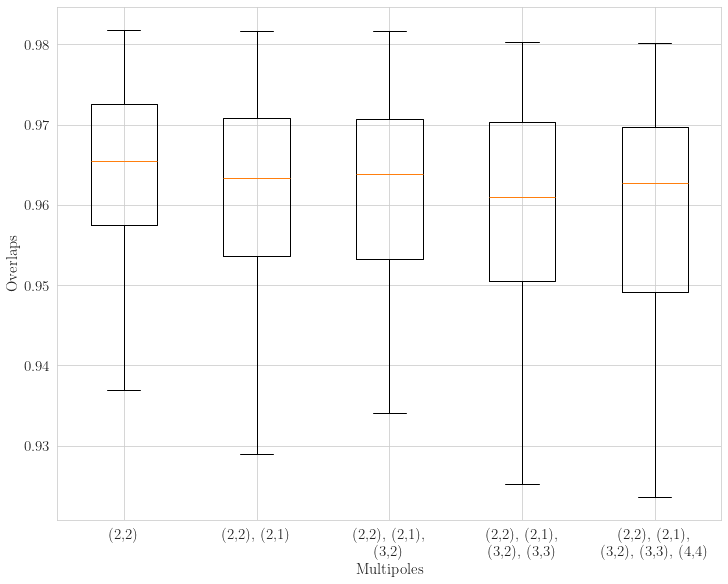

In [105]:
# Assuming overlaps_IMRPhenomXPHM and lists are defined

plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

plt.boxplot(lists, showfliers=False)
plt.xlabel('Multipoles', fontsize=15)
plt.ylabel('Overlaps', fontsize=15)
#plt.title('Box and Whiskers Plot')
plt.tick_params(labelsize=15)

# Splitting the labels into two lines and rotating them for better readability
plt.xticks(range(1, len(lists) + 1), 
           ['(2,2)', 
            '(2,2), (2,1)', 
            '(2,2), (2,1),\n(3,2)', 
            '(2,2), (2,1),\n(3,2), (3,3)', 
            '(2,2), (2,1),\n(3,2), (3,3), (4,4)'], 
           )  # Adjust the rotation angle as needed

plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_overlaps.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


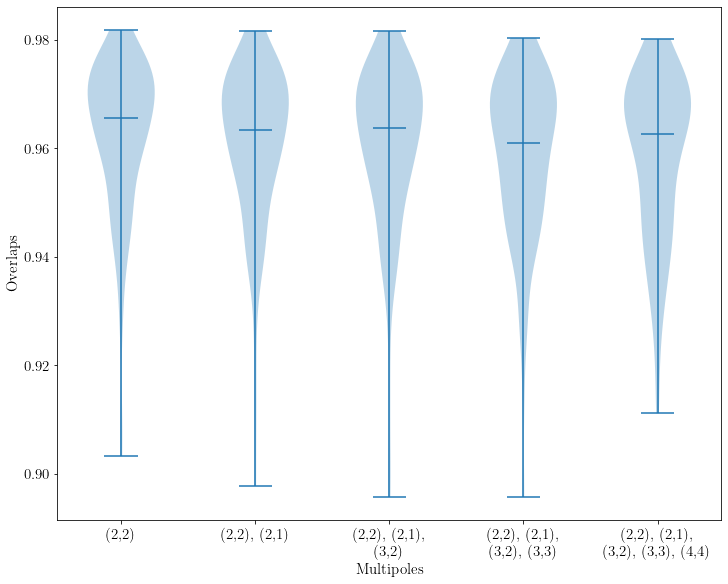

In [35]:
import matplotlib.pyplot as plt

# Assuming overlaps_IMRPhenomXPHM and lists are defined

plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

plt.violinplot(lists, showmeans=False, showmedians=True)
plt.xlabel('Multipoles', fontsize=15)
plt.ylabel('Overlaps', fontsize=15)
plt.tick_params(labelsize=15)

# Splitting the labels into two lines and rotating them for better readability
plt.xticks(range(1, len(lists) + 1), 
           ['(2,2)', 
            '(2,2), (2,1)', 
            '(2,2), (2,1),\n(3,2)', 
            '(2,2), (2,1),\n(3,2), (3,3)', 
            '(2,2), (2,1),\n(3,2), (3,3), (4,4)']
           )  # Adjust the rotation angle as needed

plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_overlaps_violin.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


In [51]:
snr_denoised = []
snr_pure = []

snr_frac = []

#f_factor = (snr[index] / snr_pure[index])

for i in range(decoded_signals.shape[0]):
    snr_denoised.append(get_snr_frac((decoded_signals[i].squeeze()).astype('float64')))
    snr_pure.append(get_snr_frac((signal[i]).astype('float64')))
    
f_factor = (snr/ snr_pure)

snr_denoised = np.array(snr_denoised)
snr_pure = np.array(snr_pure)

snr_pure = f_factor*snr_pure
snr_denoised = f_factor*snr_denoised

snr_frac = snr_denoised/snr_pure


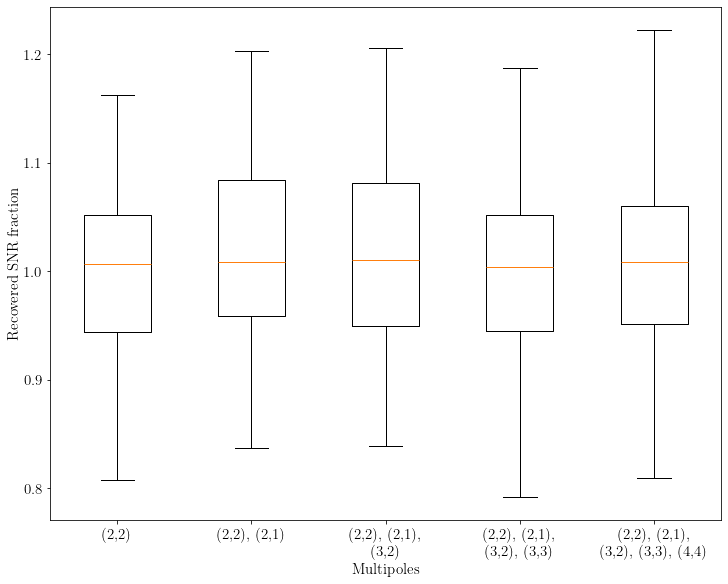

In [37]:
lists = [snr_frac[0:100],snr_frac[100:200],snr_frac[200:300],snr_frac[300:400],snr_frac[400:500]]

plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

plt.boxplot(lists, showfliers=False)
plt.xlabel('Multipoles', fontsize=15)
plt.ylabel('Recovered SNR fraction', fontsize=15)
#plt.title('Box and Whiskers Plot')
plt.tick_params(labelsize=15)

# Splitting the labels into two lines and rotating them for better readability
plt.xticks(range(1, len(lists) + 1), 
           ['(2,2)', 
            '(2,2), (2,1)', 
            '(2,2), (2,1),\n(3,2)', 
            '(2,2), (2,1),\n(3,2), (3,3)', 
            '(2,2), (2,1),\n(3,2), (3,3), (4,4)'], 
           )  # Adjust the rotation angle as needed

plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_recovered_SNR.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


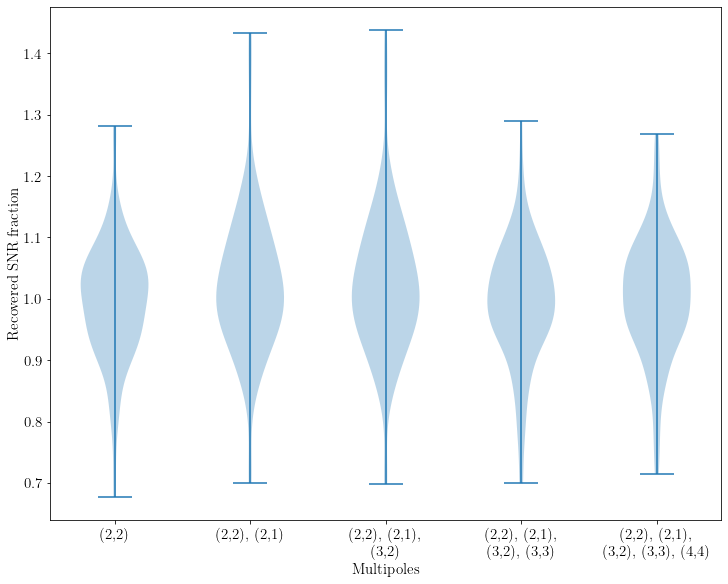

In [38]:
import matplotlib.pyplot as plt

lists = [snr_frac[0:100], snr_frac[100:200], snr_frac[200:300], snr_frac[300:400], snr_frac[400:500]]

plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

plt.violinplot(lists)
plt.xlabel('Multipoles', fontsize=15)
plt.ylabel('Recovered SNR fraction', fontsize=15)
plt.tick_params(labelsize=15)

# Splitting the labels into two lines and rotating them for better readability
plt.xticks(range(1, len(lists) + 1), 
           ['(2,2)', 
            '(2,2), (2,1)', 
            '(2,2), (2,1),\n(3,2)', 
            '(2,2), (2,1),\n(3,2), (3,3)', 
            '(2,2), (2,1),\n(3,2), (3,3), (4,4)'])

plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_recovered_SNR_violin.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


<ipython-input-52-5148e6913610>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Multipoles', y='Recovered SNR fraction', data=data_melted,


<ipython-input-52-5148e6913610>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha='center')


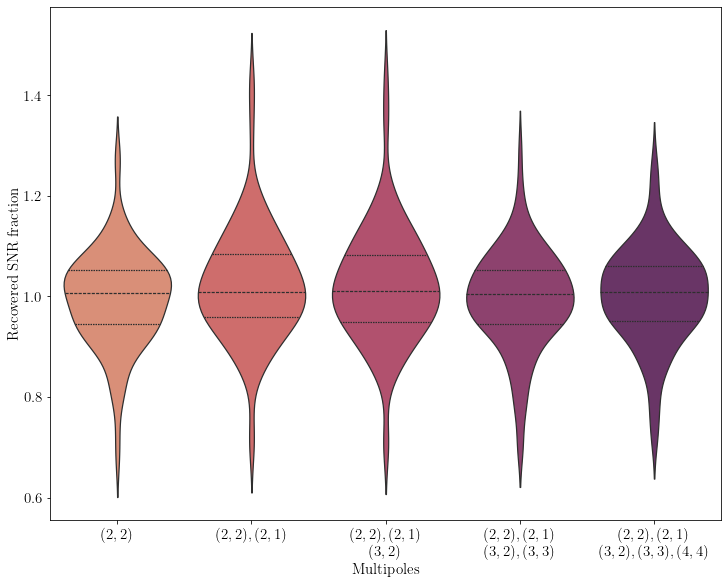

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

lists_GW190412 = [snr_frac[0:100], snr_frac[100:200], snr_frac[200:300], snr_frac[300:400], snr_frac[400:500]]

# Convert lists to a DataFrame for Seaborn
data = pd.DataFrame({f'Group {i+1}': lst for i, lst in enumerate(lists_GW190412)})

# Melt the DataFrame to have a long-form DataFrame which Seaborn prefers
data_melted = data.melt(var_name='Multipoles', value_name='Recovered SNR fraction')

# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_style("whitegrid")  # Enables gridlines

# Define a color palette for the violin plots
palette = sns.color_palette("flare", 5)  # 5 distinct colors

# Create violin plot with specified color palette
sns.violinplot(x='Multipoles', y='Recovered SNR fraction', data=data_melted, 
               inner='quartile', palette=palette)

plt.xlabel(r'$\mathrm{Multipoles}$', fontsize=15)
plt.ylabel(r'$\mathrm{Recovered\ SNR\ fraction}$', fontsize=15)
plt.tick_params(labelsize=15)

# Custom x-tick labels
labels = [r'$(2,2)$', 
          r'$(2,2), (2,1)$', 
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3), (4,4)$']  # Splitting into two lines


ax.set_xticklabels(labels, ha='center')

# Adjust specific label if necessary
for i, label in enumerate(ax.get_xticklabels()):
    
    if i == 2:  # Adjusting the third label
        label.set_horizontalalignment('center')

#plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_recovered_SNR_violin.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


In [53]:
f1 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190521_snr-35_lm_all_new.hdf', 'r')
f2 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190521_snr-35_lm_22_21_32_33_new.hdf', 'r')
f3 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190521_snr-35_lm_22_21_32_new.hdf', 'r')
f4 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190521_snr-35_lm_22_21_new.hdf', 'r')
f5 = h5py.File('/fred/oz016/Chayan/samplegen_old/output/O3b_train_IMRPhenomXPHM_mass-GW190521_snr-35_lm_22_new.hdf', 'r')

strain_1 = f1['injection_samples']['l1_strain'][()]
strain_2 = f2['injection_samples']['l1_strain'][()]
strain_3 = f3['injection_samples']['l1_strain'][()]
strain_4 = f4['injection_samples']['l1_strain'][()]
strain_5 = f5['injection_samples']['l1_strain'][()]

signal_1 = f1['injection_parameters']['l1_signal_whitened'][()]
signal_2 = f2['injection_parameters']['l1_signal_whitened'][()]
signal_3 = f3['injection_parameters']['l1_signal_whitened'][()]
signal_4 = f4['injection_parameters']['l1_signal_whitened'][()]
signal_5 = f5['injection_parameters']['l1_signal_whitened'][()]

psd_l1_1 = f1['injection_parameters']['psd_noise_l1'][()]
psd_l1_2 = f2['injection_parameters']['psd_noise_l1'][()]
psd_l1_3 = f3['injection_parameters']['psd_noise_l1'][()]
psd_l1_4 = f4['injection_parameters']['psd_noise_l1'][()]
psd_l1_5 = f5['injection_parameters']['psd_noise_l1'][()]

snr_1 = f1['injection_parameters']['l1_snr'][()]*f1['injection_parameters']['scale_factor'][()]
snr_2 = f2['injection_parameters']['l1_snr'][()]*f2['injection_parameters']['scale_factor'][()]
snr_3 = f3['injection_parameters']['l1_snr'][()]*f3['injection_parameters']['scale_factor'][()]
snr_4 = f4['injection_parameters']['l1_snr'][()]*f4['injection_parameters']['scale_factor'][()]
snr_5 = f5['injection_parameters']['l1_snr'][()]*f5['injection_parameters']['scale_factor'][()]

strain = np.concatenate([strain_5, strain_4, strain_3, strain_2, strain_1], axis=0)
signal = np.concatenate([signal_5, signal_4, signal_3, signal_2, signal_1], axis=0)
psd_l1 = np.concatenate([psd_l1_5, psd_l1_4, psd_l1_3, psd_l1_2, psd_l1_1], axis=0)
snr = np.concatenate([snr_1, snr_2, snr_3, snr_4, snr_5], axis=0)


In [54]:
strain, maximum, minimum = _preprocess_data(strain, strain.shape[0], 2048)
strain = np.array(strain)
strain.shape


(500, 2048)

In [55]:
X_test_strain = reshape_sequences(strain.shape[0], strain)
X_test_pure_signal = reshape_sequences(signal.shape[0], signal)

# Reshape arrays to fit into Keras model
X_test_strain = X_test_strain[:,:,:,None]
print('x_test_strain shape:', X_test_strain.shape)
X_test_strain = X_test_strain.astype("float32")

X_test_pure_signal = X_test_pure_signal[:,:,:,None]
print('x_test_pure_signal shape:', X_test_pure_signal.shape)
X_test_pure_signal = X_test_pure_signal.astype("float32")


x_test_strain shape: (500, 2063, 15, 1)
x_test_pure_signal shape: (500, 2063, 15, 1)


In [56]:
decoded_signals = model12.predict(X_test_strain, batch_size=50)


In [57]:
from pycbc.filter import match, overlap
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types.timeseries import TimeSeries, FrequencySeries
import matplotlib.pyplot as plt

import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

overlaps = []

def get_overlap(decoded_signal, pure_signal, psd):
    
    time_buffer = 1
    length_signal = len(decoded_signal)

    f_low = 30
    sample_rate = 2048

    # Length of corresponding time series and frequency series
    tlen = sample_rate * time_buffer
    flen = tlen // 2 + 1

    delta_f = 1.0 / time_buffer
#    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    psd = FrequencySeries(psd, delta_f=delta_f)
    
    X_test_pure_ts = TimeSeries(pure_signal.squeeze(), delta_t = 1.0/2048)
    decoded_signals_ts = TimeSeries(decoded_signal.squeeze(), delta_t = 1.0/2048)

    X_test_pure_ts.resize(tlen)
    decoded_signals_ts.resize(tlen)

    m = Overlap_calc(X_test_pure_ts,decoded_signals_ts,psd)
    
    return m

for i in range(decoded_signals.shape[0]):
    overlaps.append(get_overlap(decoded_signals[i].astype('float64'), signal[i].astype('float64'), psd_l1[i]))
    

In [58]:
overlaps_IMRPhenomXPHM = np.array(overlaps)

lists = [overlaps_IMRPhenomXPHM[0:100],overlaps_IMRPhenomXPHM[100:200],overlaps_IMRPhenomXPHM[200:300],overlaps_IMRPhenomXPHM[300:400],overlaps_IMRPhenomXPHM[400:500]]


In [59]:
snr_denoised = []
snr_pure = []

snr_frac = []

#f_factor = (snr[index] / snr_pure[index])

for i in range(decoded_signals.shape[0]):
    snr_denoised.append(get_snr_frac((decoded_signals[i].squeeze()).astype('float64')))
    snr_pure.append(get_snr_frac((signal[i]).astype('float64')))
    
f_factor = (snr/ snr_pure)

snr_denoised = np.array(snr_denoised)
snr_pure = np.array(snr_pure)

snr_pure = f_factor*snr_pure
snr_denoised = f_factor*snr_denoised

snr_frac = snr_denoised/snr_pure


<ipython-input-60-286687506d32>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Multipoles', y='Recovered SNR fraction', data=data_melted,
<ipython-input-60-286687506d32>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha='center')


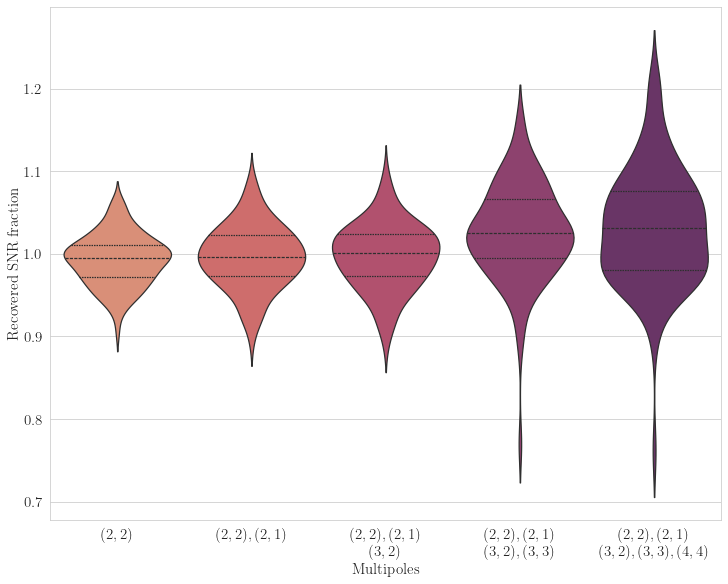

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib_latex_bridge as mlb

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

lists_GW190521 = [snr_frac[0:100], snr_frac[100:200], snr_frac[200:300], snr_frac[300:400], snr_frac[400:500]]

# Convert lists to a DataFrame for Seaborn
data = pd.DataFrame({f'Group {i+1}': lst for i, lst in enumerate(lists_GW190521)})

# Melt the DataFrame to have a long-form DataFrame which Seaborn prefers
data_melted = data.melt(var_name='Multipoles', value_name='Recovered SNR fraction')

# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_style("whitegrid")  # Enables gridlines

# Define a color palette for the violin plots
palette = sns.color_palette("flare", 5)  # 5 distinct colors

# Create violin plot with specified color palette
sns.violinplot(x='Multipoles', y='Recovered SNR fraction', data=data_melted, 
               inner='quartile', palette=palette)

plt.xlabel(r'$\mathrm{Multipoles}$', fontsize=15)
plt.ylabel(r'$\mathrm{Recovered\ SNR\ fraction}$', fontsize=15)
plt.tick_params(labelsize=15)

# Custom x-tick labels
labels = [r'$(2,2)$', 
          r'$(2,2), (2,1)$', 
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3), (4,4)$']  # Splitting into two lines


ax.set_xticklabels(labels, ha='center')

# Adjust specific label if necessary
for i, label in enumerate(ax.get_xticklabels()):
    
    if i == 2:  # Adjusting the third label
        label.set_horizontalalignment('center')

#plt.savefig('Paper_plots_new/GW190412_IMRPhenomXPHM_lm_modes_recovered_SNR_violin.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)


<ipython-input-65-ba5874fd0f44>:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, ha='center')


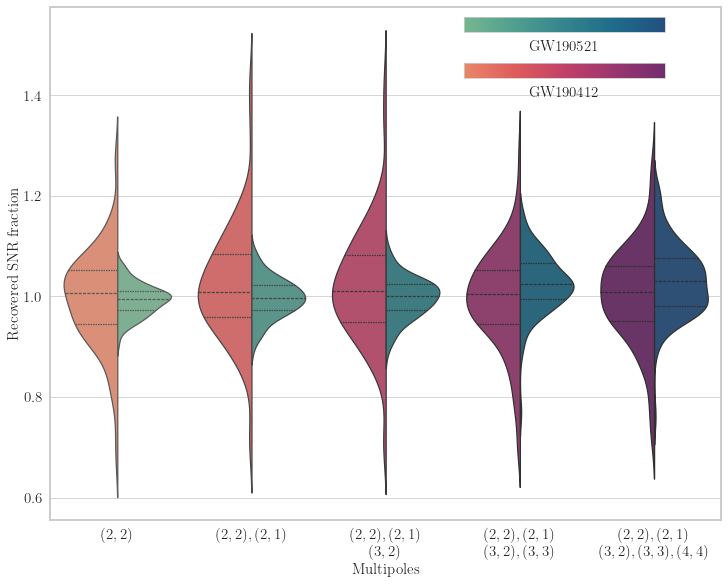

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib_latex_bridge as mlb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mlb.setup_page(**mlb.formats.article_letterpaper_10pt_singlecolumn)

# Convert lists to DataFrames for Seaborn
data_GW190412 = pd.DataFrame({f'Group {i+1}': lst for i, lst in enumerate(lists_GW190412)})
data_GW190521 = pd.DataFrame({f'Group {i+1}': lst for i, lst in enumerate(lists_GW190521)})

# Melt the DataFrames to have a long-form DataFrame which Seaborn prefers
data_melted_GW190412 = data_GW190412.melt(var_name='Multipoles', value_name='Recovered SNR fraction', ignore_index=False)
data_melted_GW190521 = data_GW190521.melt(var_name='Multipoles', value_name='Recovered SNR fraction', ignore_index=False)

# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_style("whitegrid")  # Enables gridlines

# Define the color palettes
palette_flare = sns.color_palette("flare", n_colors=5)
palette_crest = sns.color_palette("crest", n_colors=5)

# Combine datasets for easier handling
combined_data = pd.concat([data_melted_GW190412.assign(Event='GW190412'),
                           data_melted_GW190521.assign(Event='GW190521')])

# Plot each group separately
for i, group in enumerate(data_GW190412.columns):
    sns.violinplot(x='Multipoles', y='Recovered SNR fraction', data=combined_data[combined_data['Multipoles'] == group],
                   hue='Event', split=True, inner='quartile', palette=[palette_flare[i], palette_crest[i]], ax=ax)

plt.xlabel(r'$\mathrm{Multipoles}$', fontsize=15)
plt.ylabel(r'$\mathrm{Recovered\ SNR\ fraction}$', fontsize=15)
plt.tick_params(labelsize=15)

# Custom x-tick labels
labels = [r'$(2,2)$', 
          r'$(2,2), (2,1)$', 
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3)$',  # Splitting into two lines
          r'$(2,2), (2,1)$' + '\n' + r'$(3,2), (3,3), (4,4)$']  # Splitting into two lines


ax.set_xticklabels(labels, ha='center')

# Remove the legend
ax.legend_.remove()

# Thicken the border of the plot
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the thickness here

# Create inset axes for color bars
axins1 = inset_axes(ax, width="30%", height="3%", loc='upper right', borderpad=7)
axins2 = inset_axes(ax, width="30%", height="3%", loc='upper right', borderpad=7, bbox_to_anchor=(0, 0.09, 1, 1), bbox_transform=ax.transAxes)

# Create a colorbar in the inset axes
cmap_flare = mcolors.LinearSegmentedColormap.from_list("flare", palette_flare)
cmap_crest = mcolors.LinearSegmentedColormap.from_list("crest", palette_crest)

sm = plt.cm.ScalarMappable(cmap=cmap_flare, norm=plt.Normalize(vmin=0, vmax=5))
cb1 = plt.colorbar(sm, cax=axins1, orientation='horizontal')
cb1.set_ticks([])
cb1.set_label(r'$\textnormal{GW190412}$', fontsize=15, labelpad=8)

sm = plt.cm.ScalarMappable(cmap=cmap_crest, norm=plt.Normalize(vmin=0, vmax=5))
cb2 = plt.colorbar(sm, cax=axins2, orientation='horizontal')
cb2.set_ticks([])
cb2.set_label(r'$\textnormal{GW190521}$', fontsize=15, labelpad=8)

plt.savefig('Paper_plots_new/GW190412_and_GW190521_IMRPhenomXPHM_lm_modes_recovered_SNR_violin.png', bbox_inches="tight", facecolor='w', transparent=False, dpi=400)



In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
axs[0].plot(x, y ** 2)
axs[1].plot(x, 0.3 * y, 'o')
axs[2].plot(x, y, '+')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()